In [11]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','cf_inf_on1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# on ice corsi
player_onIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_onIce_corsi = players_df.loc[[player]]["onIce_corsiPercentage"].values[0]
    player_onIce_corsis[player] = player_onIce_corsi

nx.set_node_attributes(G, player_onIce_corsis, "onIce_corsiPercentage")

# off ice corsi
player_offIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_offIce_corsi = players_df.loc[[player]]["offIce_corsiPercentage"].values[0]
    player_offIce_corsis[player] = player_offIce_corsi

nx.set_node_attributes(G, player_offIce_corsis, "offIce_corsiPercentage")

# on/off ice corsi diff
player_corsi_diffs = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_corsi_diff = players_df.loc[[player]]["on_off_corsi_diff"].values[0]
    player_corsi_diffs[player] = player_corsi_diff

nx.set_node_attributes(G, player_corsi_diffs, "on_off_corsi_diff")

# on ice goals for per 60
player_gf_per60s = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_gf_per60 = players_df.loc[[player]]["OnIce_F_goals_per60"].values[0]
    player_gf_per60s[player] = player_gf_per60

nx.set_node_attributes(G, player_gf_per60s, "onIce_F_goals_per60")

# d zone giveaways per 60
players_dz_giveaways = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_dz_giveaways = players_df.loc[[player]]["I_F_dZoneGiveaways_per60"].values[0]
    players_dz_giveaways[player] = player_dz_giveaways

nx.set_node_attributes(G, players_dz_giveaways, "I_F_dZoneGiveaways_per60")

# average icetime
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_TOI"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_TOI")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_corsi_influence"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_corsi_influence")


In [12]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

Number of nodes:  758
Number of edges:  4442


In [13]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'forwards-positive.gexf')

In [14]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 10 games to clean up playerbase data a bit
players_df = players_df.drop(players_df[players_df.games_played < 10].index)

In [17]:
def plot_distributions(stat):
    # Plot corsi influence distribution of entire playerbase
    playerbase_stats = players_df[stat].values
    print("n: ", len(playerbase_stats))
    print("mean: ", np.nanmean(playerbase_stats))
    print("std dev: ",np.nanstd(playerbase_stats))
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot corsi distribution of each community individually
    graph_stats = dict(G.nodes(data=stat, default=1))
    i = 0
    for community in greedy_communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print("std dev: ",np.std(players_stats))
        plt.hist(players_stats, bins)
        plt.xlabel(stat)
        plt.ylabel("Count")
        title = "Community: " + str(i)
        plt.title(title)
        plt.show()
        i += 1

n:  1159
mean:  0.4850550228449162
std dev:  0.03983257915153573


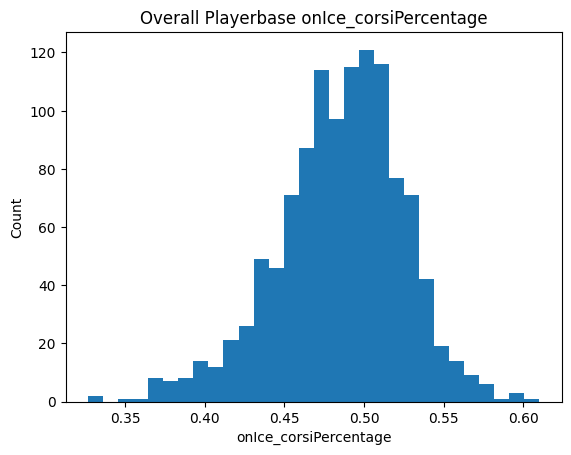

n:  66
mean:  0.4874437685894491
std dev:  0.02486646763085625


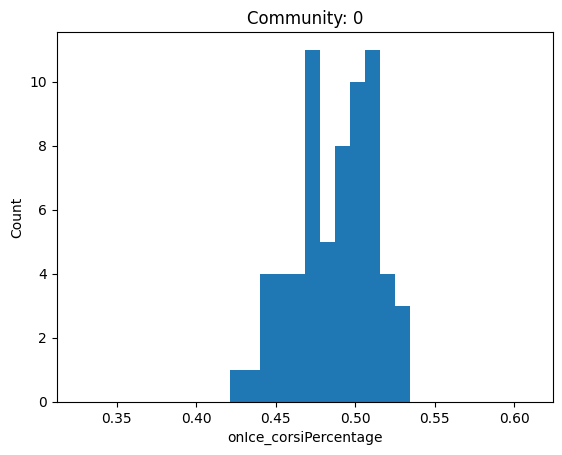

n:  63
mean:  0.5062829797350847
std dev:  0.029528855948482337


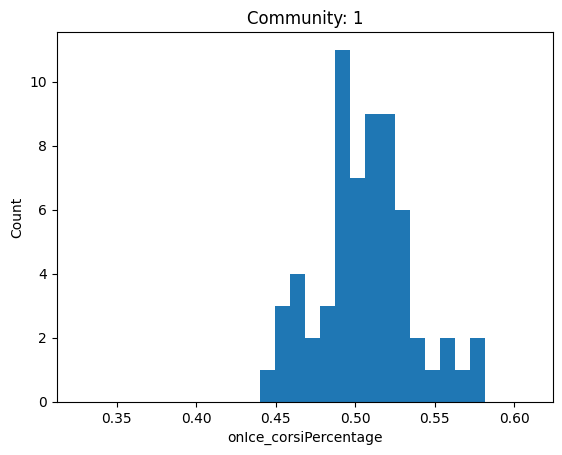

n:  57
mean:  0.48899102005078626
std dev:  0.025959129609100164


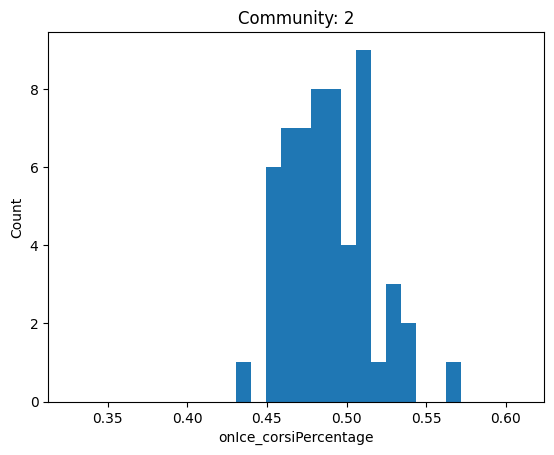

n:  56
mean:  0.4912060825140223
std dev:  0.026918436073314508


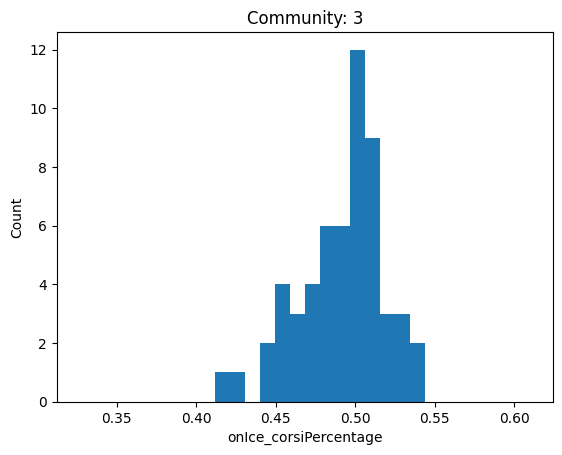

n:  55
mean:  0.49732798407169554
std dev:  0.03153609930743366


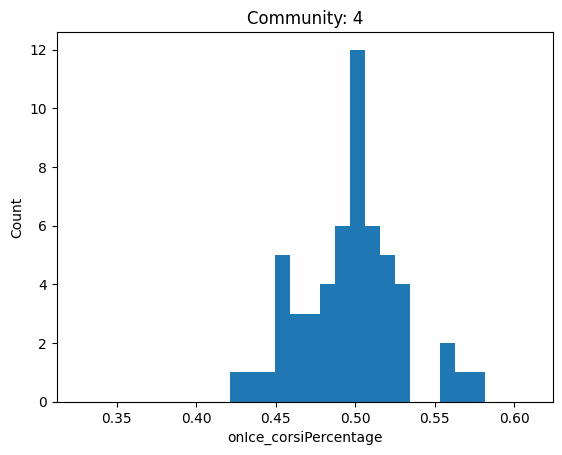

n:  54
mean:  0.4934685481928597
std dev:  0.033942723406738935


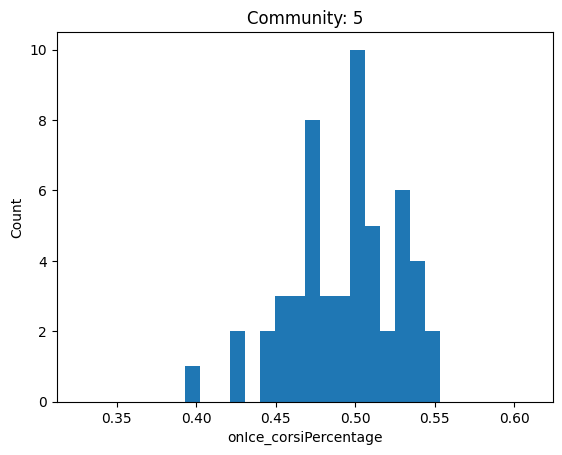

n:  51
mean:  0.4948850099241367
std dev:  0.03466446595184713


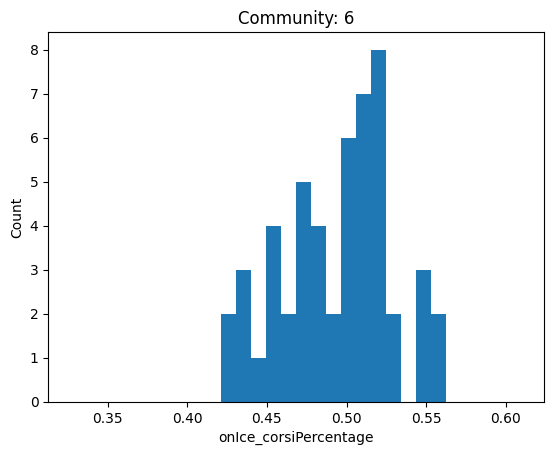

n:  50
mean:  0.49235217168125606
std dev:  0.03594546060767133


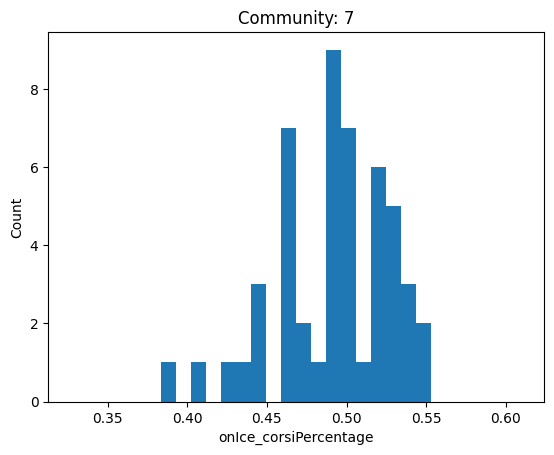

n:  45
mean:  0.4864430491196978
std dev:  0.02953669350596983


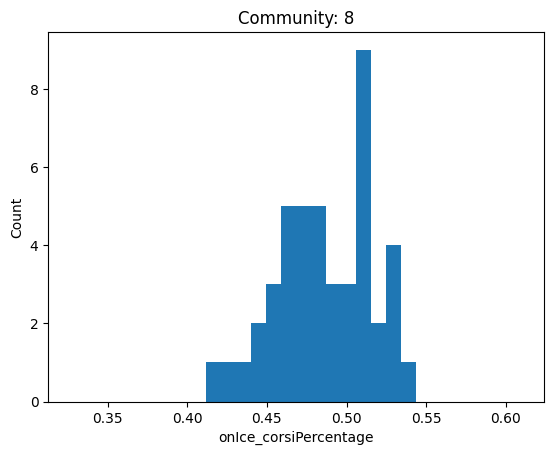

n:  39
mean:  0.4911246513988021
std dev:  0.029880862890366868


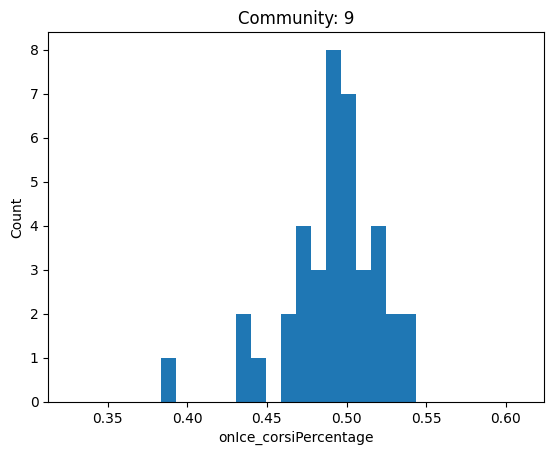

n:  38
mean:  0.5090006812083461
std dev:  0.027833436865553222


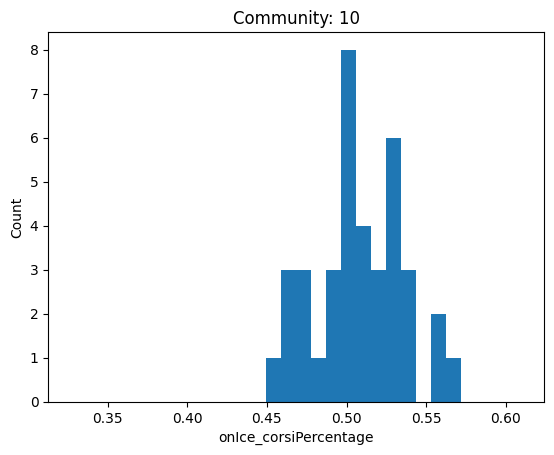

n:  37
mean:  0.5072839956016264
std dev:  0.039233834492382116


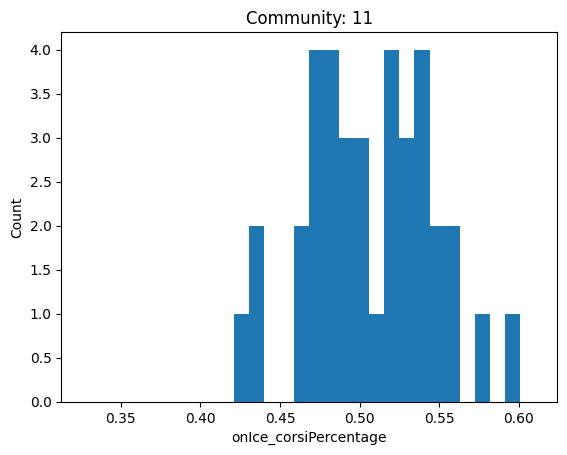

n:  36
mean:  0.5095957989697539
std dev:  0.030358183897590124


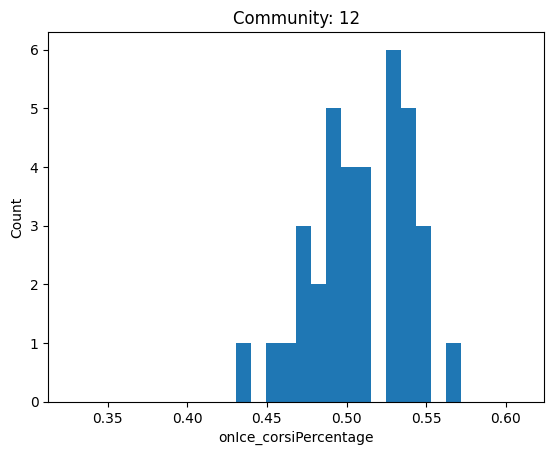

n:  28
mean:  0.49765526758313455
std dev:  0.023716727285561387


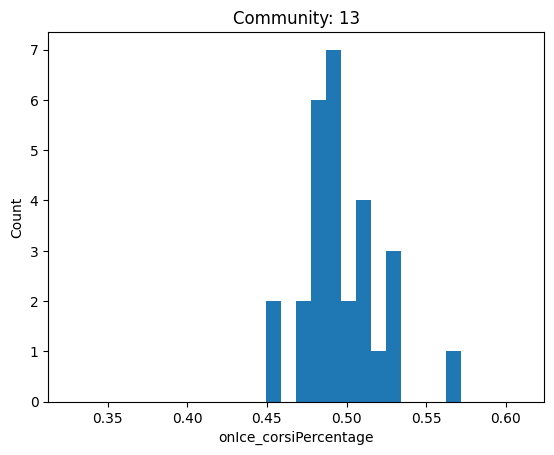

n:  27
mean:  0.4914946267618486
std dev:  0.026513847544163707


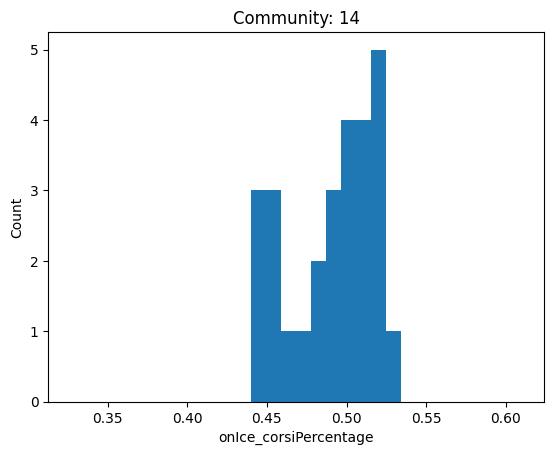

n:  19
mean:  0.5130261549777227
std dev:  0.030859035690747463


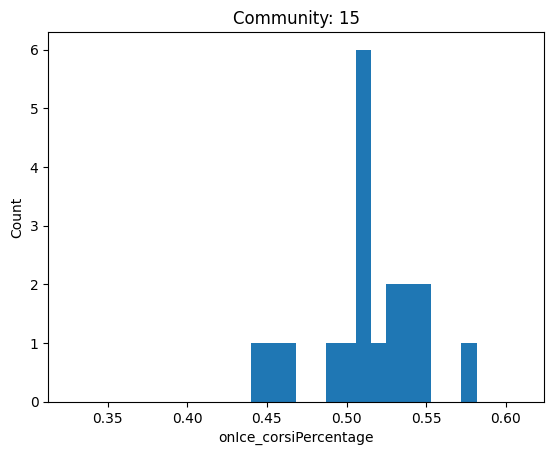

n:  17
mean:  0.4920124233144404
std dev:  0.027127023921966215


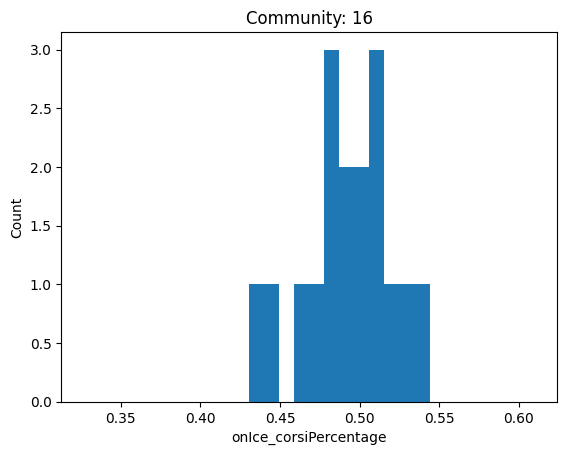

n:  9
mean:  0.4749771412877854
std dev:  0.02878603577962881


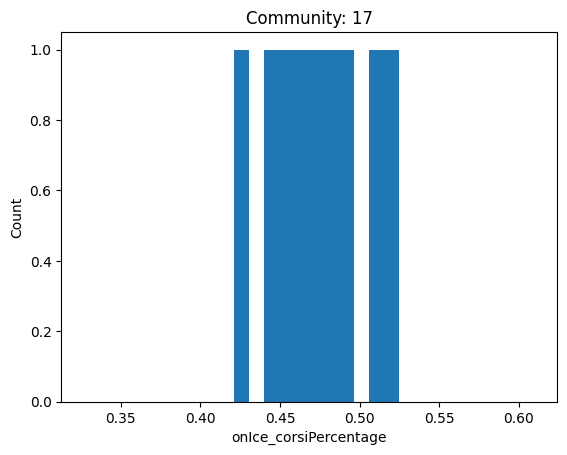

n:  8
mean:  0.4706740219468132
std dev:  0.022801343987381775


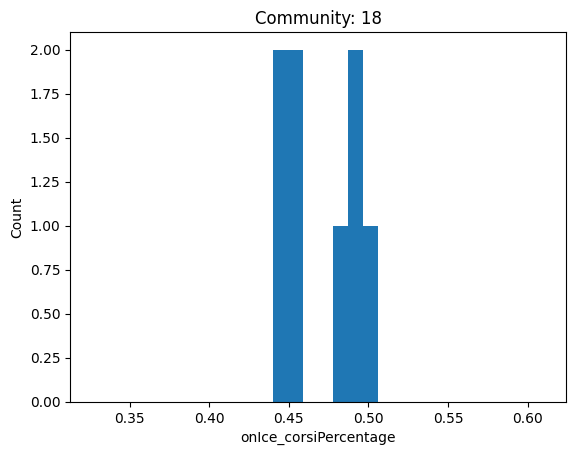

n:  3
mean:  0.49155706560487644
std dev:  0.01193222026105216


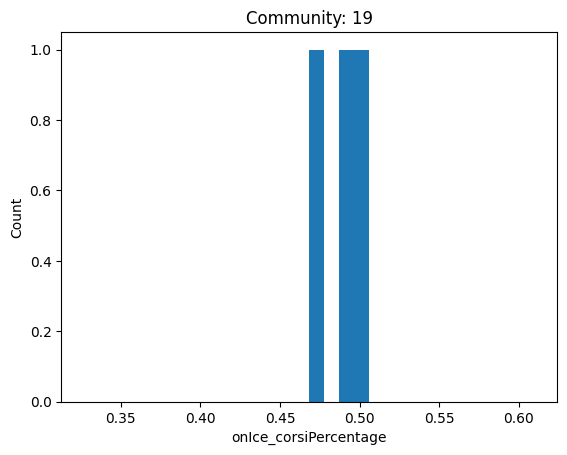

In [18]:
# Plot corsi influence distribution of entire playerbase
plot_distributions("shotsBlockedByPlayer_per60")
